# (Supplementary) Capstone Project Part 3: Topic Modeling with LDA

**Author:** Soohyun Ahn <br>
    
**Date:** April 2023<br>
    
**Notebook Number:** 3/ 4

### Important Note:

This notebook contains interactive visualizations created by PyLDAvis, which cannot be displayed here. To fully interact with them, please use `Jupyter Notebook Viewer`. Click **[here](https://nbviewer.org/github/treelunar/2023_Capstone_BSTN/blob/main/Supplementary/Supplementary_Part_3_Topic_Modeling_LDA_MPST.ipynb)** to access the viewer.

In this notebook, we will explore topic modeling via `Latent Dirichlet Allocation` (LDA). LDA is an unsupervised learning algorithm, meaning it learns from the data without any explicit guidance or supervision. In LDA, the algorithm takes a corpus of text documents and learns a set of (hidden or latent) topics that best represent the corpus. The algorithm assumes that each document in the corpus is a mixture of these topics, and each word in the document is generated by one of the topics in the document's mixture. LDA works by assigning each word in the document to a topic and adjusting the assignments iteratively until it arrives at a stable topic distribution for each document. Once the model identifies the topics, it can classify new documents or analyze the distribution of topics across a corpus.

**Note**:
This notebook is supplementary to our main notebook [**Part_3_Topic_Modeling_and Clustering**](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Part_3_Topic_Modeling_Clustering.ipynb).

## Dataset Inspection & Preprocessing Continued

Let's import our dataset, take a look at it, and further process it (if needed).

In [2]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gensim
import pyLDAvis.gensim_models

# hide warnings

import warnings
warnings.filterwarnings('ignore')

# Set the random seed

random.seed(42)
np.random.seed(42)

In [5]:
# Import dataset

ada_mpst_df = pd.read_csv("ada_embeddings_mpst_v4.csv")
ada_mpst_df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...,619,[ 0.00162488 -0.01722533 0.01495554 ... 0.01...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...,189,[-0.00060418 -0.00506717 0.01369084 ... -0.01...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...,335,[-0.01204982 -0.01335701 0.0008774 ... -0.00...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...,1074,[-0.00985113 0.00062676 0.00801298 ... -0.00...
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...,1366,[-0.0231264 -0.01031728 0.00604758 ... -0.00...


In [8]:
# Check null values
ada_mpst_df.isnull().sum()

imdb_id                0
title                  0
plot_synopsis          0
tags                   0
split                  0
synopsis_source        0
en_title           13740
overview               0
num_tokens             0
ada_embeddings         0
dtype: int64

In the previous notebook, we scraped English titles for non-English titled movies and saved the titles in the `title` column. Thus, NaNs in the `en_title` column is not an issue.

In [9]:
# Check the datasetm
ada_mpst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14165 entries, 0 to 14164
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14165 non-null  object
 1   title            14165 non-null  object
 2   plot_synopsis    14165 non-null  object
 3   tags             14165 non-null  object
 4   split            14165 non-null  object
 5   synopsis_source  14165 non-null  object
 6   en_title         425 non-null    object
 7   overview         14165 non-null  object
 8   num_tokens       14165 non-null  int64 
 9   ada_embeddings   14165 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.1+ MB


Let's create a wordcloud for the `overview` so that we can get the sense of the most frequent words across all the synopses.

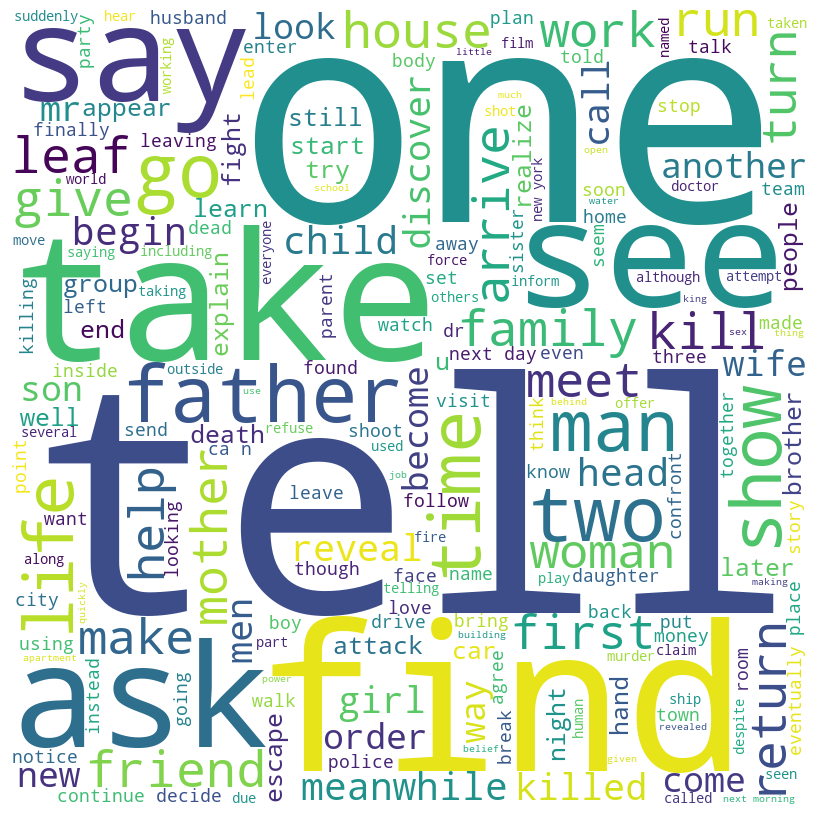

In [10]:
from wordcloud import WordCloud

# Concatenate the `overviews` into a single string
text = ' '.join(ada_mpst_df['overview'])

# Create a wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the wordcloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Important (or common) words are larger in their font size. We can see that `tell`, `one`, `find`, `take`, `ask`, and `see` are frequent words.

## Topic Modeling with LDA

Now we can conduct topic modeling with LDA. It assigns topics to each synopsis document, where a topic is a distribution over words. We specify the number of topics as 10 and the number of passes through the corpus as 10. There are different methods of performing LDA. For our project,we will use `pyLDAvis`, which is a Python library that provides an interactive visualization of the topics extracted from the text. We can set the `num_topics` inbetween 10 and 16.

In [11]:
#pip install pyLDAvis
from IPython.core.display import HTML
from gensim import corpora, models

# Create dictionary and corpus
dictionary = corpora.Dictionary(ada_mpst_df['overview'].apply(lambda x: x.split()))
corpus = [dictionary.doc2bow(doc) for doc in ada_mpst_df['overview'].apply(lambda x: x.split())]

In [12]:
# Train LDA model
num_topics = 10
lda_model_10 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz10 = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, dictionary)
pyLDAvis.display(viz10)

The PyLDAvis visualization disappears once the Jupyter notebookis closed or the computer is shut down.<br>We can save the PyLDAvis visualization as an HTML file using the `save_html()` function.

In [13]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz10, 'lda_viz_mpst_10.html')

[View the LDA 10 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/blob/main/HTML_PyLDAvis/lda_visualization_10.html)

PyLDAvis assigns topic numbers based on the size of the topic, with the largest topic being assigned the number 1, the second largest being assigned the number 2, and so on. Thus, potentially there can be mismatch between the topic numbers in the visual and the printed-out result. To prevent this mismatch, we can use `lda_model.show_topics()` that assigns topic numbers based on their order of appearance in the model output, with the first topic being assigned the number 0, the second topic being assigned the number 1, and so on.

In [14]:
# Print out top words for each topic in the order that matches the visual

num_topics = 10

for topic_idx, topic in lda_model_10.show_topics(formatted=False):
    viz10_topic_idx = viz10.topic_order.index(topic_idx+1)
    print(f'Top 10 Words for Topic #{viz10_topic_idx+1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #8:
['king', 'fight', 'one', 'battle', 'return', 'dragon', 'year', 'take', 'father', 'order']
Top 10 Words for Topic #6:
['find', 'body', 'dr', 'kill', 'man', 'one', 'book', 'zombie', 'back', 'help']
Top 10 Words for Topic #7:
['soldier', 'men', 'war', 'german', 'army', 'officer', 'killed', 'american', 'one', 'british']
Top 10 Words for Topic #4:
['film', 'new', 'one', 'life', 'also', 'time', 'prison', 'show', 'work', 'end']
Top 10 Words for Topic #10:
['el', 'marcello', 'carver', 'vallo', 'godfrey', 'rocky', 'elena', 'de', 'la', 'gideon']
Top 10 Words for Topic #1:
['tell', 'say', 'n', 'go', 'get', 'see', 'back', 'asks', 'one', 'come']
Top 10 Words for Topic #9:
['town', 'men', 'kill', 'take', 'gang', 'father', 'village', 'horse', 'killed', 'find']
Top 10 Words for Topic #2:
['father', 'love', 'mother', 'home', 'family', 'friend', 'go', 'life', 'day', 'tell']
Top 10 Words for Topic #5:
['ship', 'find', 'crew', 'escape', 'back', 'take', 'alien', 'team', 'one', 'e

Based on the LDA analysis results, we can infer the likely genres for each topic.<Br>While some genres are clearly distinguishable in a movie, many movies contain overlapping genres.<br>The LDA analysis suggests that classifying movies into 10 genres provides a reasonable approximation. 

| **Topic** |                                    **Top 10 Salient Words**                                   |              **Genres**             |
|:---------:|----------------------------------------------------------------------------------------------:|------------------------------------:|
| #1        | 'tell', 'say', 'n', 'go', 'get', 'see', 'back', 'asks', 'one', 'come'                         | any genres...                       |
| #2        | 'father', 'love', 'mother', 'home', 'family', 'friend', 'go', 'life', 'day', 'tell'           | Family, Drama                       |
| #3        | 'police', 'car', 'find', 'kill', 'go', 'get', 'house', 'tell', 'man', 'back'                  | Action, Crime, Mystery              |
| #4        | 'film', 'new', 'one', 'life', 'also', 'time', 'prison', 'show', 'work', 'end'                 | Action, Drama, Documentary          |
| #5        | 'ship', 'find', 'crew', 'escape', 'back', 'take', 'alien', 'team', 'one', 'earth'             | Mystery, Sci-fi, Horror, Adventure  |
| #6        | 'find', 'body', 'dr', 'kill', 'man', 'one', 'book', 'zombie', 'back', 'help'                  | Mystery, Sci-fi, Horror, Adventure  |
| #7        | 'soldier', 'men', 'war', 'german', 'army', 'officer', 'killed', 'american', 'one', 'british'  | War, History                        |
| #8        | 'king', 'fight', 'one', 'battle', 'return', 'dragon', 'year', 'take', 'father', 'order'       | Fantasy, History, Adventure         |
| #9        | 'town', 'men', 'kill', 'take', 'gang', 'father', 'village', 'horse', 'killed', 'find'         | Action, Mystery, Horror, Adventure  |
| #10       | 'el', 'marcello', 'carver', 'vallo', 'godfrey', 'rocky', 'elena', 'de', 'la', 'gideon'        | Drama, Documentary, History         |
    
Again, matching genres is very subjective.

Let's run the next model with `num_topics = 12`.

In [15]:
# Train LDA model
num_topics = 12
lda_model_12 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz12 = pyLDAvis.gensim_models.prepare(lda_model_12, corpus, dictionary)
pyLDAvis.display(viz12)

[View the LDA 12 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/blob/main/HTML_PyLDAvis/lda_visualization_12.html)

In [16]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz12, 'lda_viz_mpst_12.html')

In [17]:
# Print out top words for each topic in the order that matches the visual

num_topics = 12

for topic_idx in range(num_topics):
    topic = lda_model_12.show_topic(topic_idx)
    viz12_topic_idx = viz12.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz12_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #8:
['king', 'sir', 'father', 'son', 'death', 'one', 'return', 'love', 'take', 'village']
Top 10 Words for Topic #6:
['find', 'dr', 'body', 'power', 'kill', 'world', 'one', 'human', 'man', 'help']
Top 10 Words for Topic #7:
['men', 'war', 'soldier', 'german', 'army', 'officer', 'killed', 'american', 'agent', 'one']
Top 10 Words for Topic #4:
['film', 'life', 'one', 'new', 'also', 'time', 'end', 'year', 'show', 'first']
Top 10 Words for Topic #11:
['marcello', 'jake', 'carver', 'fight', 'nicky', 'sequence', 'round', 'bomb', 'fisher', 'gideon']
Top 10 Words for Topic #1:
['tell', 'say', 'get', 'n', 'go', 'see', 'back', 'asks', 'one', 'come']
Top 10 Words for Topic #9:
['town', 'kill', 'men', 'find', 'killed', 'horse', 'take', 'sheriff', 'one', 'back']
Top 10 Words for Topic #2:
['father', 'love', 'mother', 'home', 'go', 'friend', 'family', 'tell', 'day', 'life']
Top 10 Words for Topic #5:
['ship', 'find', 'crew', 'escape', 'back', 'alien', 'take', 'one', 'earth', '

Again, it is difficult to determine specific movie genres based on these words. But we can try..

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #1        | 'tell', 'say', 'get', 'n', 'go', 'see', 'back', 'asks', 'one', 'come'                                   | any genres...                |
| #2        | 'father', 'love', 'mother', 'home', 'go', 'friend', 'family', 'tell', 'day', 'life'                     | Drama, Family, Romance       |
| #3        | 'police', 'find', 'car', 'kill', 'house', 'go', 'get', 'tell', 'man', 'back'                            | Action, Mystery, Crime       |
| #4        | 'film', 'life', 'one', 'new', 'also', 'time', 'end', 'year', 'show', 'first'                            | Documentary, Action, Drama   |
| #5        | 'ship', 'find', 'crew', 'escape', 'back', 'alien', 'take', 'one', 'earth', 'group'                      | Sci-fi, Mystery, Horror, Adventure                |
| #6        | 'find', 'dr', 'body', 'power', 'kill', 'world', 'one', 'human', 'man', 'help'                           | Thriller, Mystery, Horror    |
| #7        | 'men', 'war', 'soldier', 'german', 'army', 'officer', 'killed', 'american', 'agent', 'one'              | War, History                 |
| #8        | 'king', 'sir', 'father', 'son', 'death', 'one', 'return', 'love', 'take', 'village'                     | Adventure, Drama, Romance, History      |
| #9        | 'town', 'kill', 'men', 'find', 'killed', 'horse', 'take', 'sheriff', 'one', 'back'                      | Action, Adventure, History   |
| #10       | 'kishen', 'karan', 'duke', 'curtis', 'child', 'princess', 'stephen', 'clarence', 'fairy', 'ursula'      | Fantasy, Adventure           |
| #11       | 'marcello', 'jake', 'carver', 'fight', 'nicky', 'sequence', 'round', 'bomb', 'fisher', 'gideon'         | History, Fantasy, Drama      |
| #12       | 'c', 'el', 'e', 'vallo', 'l', 'h', 'rocky', 'la', 'de', 'le'                                            | ??                           |

Topic #12 doesn't look great since it contains lots of single letters and very short strings, which may not hold much meaningful information.
In one of our previous notebooks, [**(Supplementary)Part_1_Data_Preprocessing_MPST.ipynb**](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Supplementary/Supplementary_Part_1_Data_Preprocessing_MPST.ipynb), we preprocessed text data.<br>
We removed people names, non-alphabetical terms, lowercasing, removing stopwords, and so on.<br>The process might have been incomplete.

In [18]:
# Train LDA model
num_topics = 14
lda_model_14 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz14 = pyLDAvis.gensim_models.prepare(lda_model_14, corpus, dictionary)
pyLDAvis.display(viz14)

In [21]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz14, 'lda_viz_mpst_14.html')

[View the LDA 14 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/blob/main/HTML_PyLDAvis/lda_visualization_14.html)

In [22]:
# Print out top words for each topic in the order that matches the visual

num_topics = 14

for topic_idx in range(num_topics):
    topic = lda_model_14.show_topic(topic_idx)
    viz14_topic_idx = viz14.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz14_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #6:
['king', 'one', 'return', 'world', 'take', 'power', 'find', 'castle', 'kill', 'father']
Top 10 Words for Topic #7:
['body', 'dr', 'find', 'man', 'house', 'zombie', 'back', 'dead', 'doctor', 'room']
Top 10 Words for Topic #11:
['fight', 'team', 'game', 'gang', 'c', 'one', 'w', 'man', 'family', 'win']
Top 10 Words for Topic #4:
['film', 'one', 'new', 'life', 'also', 'time', 'end', 'show', 'first', 'story']
Top 10 Words for Topic #12:
['money', 'bank', 'get', 'marcello', 'gang', 'plan', 'escape', 'police', 'robbery', 'duke']
Top 10 Words for Topic #10:
['cat', 'get', 'dog', 'red', 'cecil', 'head', 'fall', 'back', 'end', 'show']
Top 10 Words for Topic #9:
['town', 'men', 'kill', 'village', 'horse', 'sheriff', 'take', 'vampire', 'man', 'killed']
Top 10 Words for Topic #2:
['love', 'father', 'mother', 'home', 'friend', 'go', 'family', 'life', 'tell', 'day']
Top 10 Words for Topic #5:
['ship', 'find', 'crew', 'escape', 'take', 'back', 'alien', 'earth', 'team', 'one'

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #1        | 'tell', 'go', 'get', 'say', 'n', 'see', 'back', 'asks', 'one', 'room'                                   | any genres...                |
| #2        | 'love', 'father', 'mother', 'home', 'friend', 'go', 'family', 'life', 'tell', 'day'                     | Drama, Family, Romance       |
| #3        | 'police', 'kill', 'find', 'car', 'killed', 'murder', 'house', 'go', 'get', 'take'                       | Action, Mystery, Crime       | 
| #4        | 'film', 'one', 'new', 'life', 'also', 'time', 'end', 'first', 'show', 'story'                           | Documentary, Action          |
| #5        | 'ship', 'find', 'crew', 'escape', 'take', 'back', 'alien', 'earth', 'city', 'team'                      | Sci-fi, Horror, Adventure    |
| #6        | 'king', 'one', 'return', 'battle', 'power', 'world', 'year', 'take', 'life', 'time'                     | Fantasy, Adventure, History  |
| #7        | 'body', 'dr', 'find', 'man', 'house', 'zombie', 'one', 'back', 'room', 'dead'                           | Fantasy, Sci-fi, Horror      |
| #8        | 'soldier', 'war', 'german', 'men', 'agent', 'army', 'officer', 'british', 'american', 'killed'          | Adventure, Drama, History    |
| #9        | 'town', 'men', 'kill', 'village', 'horse', 'sheriff', 'take', 'vampire', 'man', 'killed'                | Action, Adventure, History   |
| #10       | 'cat', 'get', 'dog', 'red', 'cecil', 'head', 'fall', 'back', 'end', 'show'                              | Fantasy, Adventure           |
| #11       | 'fight', 'team', 'game', 'gang', 'c', 'one', 'w', 'man', 'family', 'win'                                | Action, Crime                |
| #12       | 'money', 'bank', 'get', 'marcello', 'gang', 'plan', 'escape', 'police', 'robbery', 'duke'               | Action, Crime, Adventure     |
| #13       | 'el', 'x', 'e', 'l', 'logan', 'wolverine', 'rocky', 'de', 'h', 'la'                                     | Sci-fi, Fantasy, Drama       |
| #14       | 'kishen', 'karan', 'curtis', 'bart', 'stephen', 'vivian', 'ursula', 'julian', 'sara', 'stanley'         | Fantasy, Adventure, History  |

We have seen three LDA models so far. Some topics consistently appear in all three models.

In [19]:
# Train LDA model
num_topics = 16
lda_model_16 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz16 = pyLDAvis.gensim_models.prepare(lda_model_16, corpus, dictionary)
pyLDAvis.display(viz16)

In [23]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz16, 'lda_viz_mpst_16.html')

[View the LDA 16 Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/blob/main/HTML_PyLDAvis/lda_visualization_16.html)

In [24]:
# Print out top words for each topic in the order that matches the visual

num_topics = 16

for topic_idx in range(num_topics):
    topic = lda_model_16.show_topic(topic_idx)
    viz16_topic_idx = viz16.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz16_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #7:
['king', 'one', 'father', 'return', 'take', 'find', 'two', 'son', 'however', 'village']
Top 10 Words for Topic #9:
['dr', 'find', 'kill', 'body', 'man', 'zombie', 'power', 'monster', 'one', 'town']
Top 10 Words for Topic #13:
['fight', 'game', 'team', 'player', 'one', 'win', 'victoria', 'defeat', 'batman', 'named']
Top 10 Words for Topic #4:
['film', 'one', 'new', 'life', 'time', 'also', 'first', 'show', 'end', 'story']
Top 10 Words for Topic #8:
['money', 'kill', 'gang', 'take', 'men', 'get', 'town', 'shoot', 'escape', 'gun']
Top 10 Words for Topic #11:
['song', 'get', 'show', 'cat', 'end', 'cecil', 'band', 'dog', 'head', 'red']
Top 10 Words for Topic #14:
['vampire', 'count', 'village', 'priest', 'church', 'castle', 'villager', 'ichi', 'vivian', 'werewolf']
Top 10 Words for Topic #1:
['father', 'love', 'mother', 'family', 'home', 'friend', 'go', 'life', 'day', 'tell']
Top 10 Words for Topic #6:
['find', 'crew', 'ship', 'group', 'back', 'escape', 'boat', 'is

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #1        | 'father', 'love', 'mother', 'family', 'home', 'friend', 'go', 'life', 'day', 'tell'                     | Drama, Family, Romance       |
| #2        | 'tell', 'see', 'say', 'back', 'n', 'go', 'one', 'asks', 'room', 'man'                                   | any genres...                |
| #3        | 'get', 'tell', 'go', 'car', 'n', 'back', 'say', 'see', 'take', 'find'                                   | any genres...                | 
| #4        | 'film', 'one', 'new', 'life', 'time', 'also', 'first', 'show', 'end', 'story'                           | Documentary, Action          |
| #5        | 'police', 'find', 'house', 'murder', 'kill', 'death', 'killed', 'body', 'car', 'later'                  | Mystery, Horror, Action, Crime    |
| #6        | 'find', 'crew', 'ship', 'group', 'back', 'escape', 'boat', 'island', 'attempt', 'two'                   | Sci-fi, Adventure, Fantasy   |
| #7        | 'king', 'one', 'father', 'return', 'take', 'find', 'two', 'son', 'however', 'village'                   | Action, Crime                |
| #8        | 'money', 'kill', 'gang', 'take', 'men', 'get', 'town', 'shoot', 'escape', 'gun'                         | Adventure, Drama, History    |
| #9        | 'dr', 'find', 'kill', 'body', 'man', 'zombie', 'power', 'monster', 'one', 'town'                        | Sci-fi, Fantasy, Horror      |
| #10       | 'soldier', 'war', 'german', 'men', 'army', 'british', 'officer', 'american', 'agent', 'killed'          | War, History                 |
| #11       | 'song', 'get', 'show', 'cat', 'end', 'cecil', 'band', 'dog', 'head', 'red'                              | Musical, Fantasy, Adventure  |
| #12       | 'earth', 'c', 'alien', 'x', 'robot', 'planet', 'space', 'w', 'human', 'weapon'                          | Sci-fi, Adventure            |
| #13       | 'fight', 'game', 'team', 'player', 'one', 'win', 'victoria', 'defeat', 'batman', 'named'                | Fantasy, Adventure, Action   |
| #14       | 'vampire', 'count', 'village', 'priest', 'church', 'castle', 'villager', 'ichi', 'vivian', 'werewolf'   | Fantasy, Horror, Adventure   |
| #15       | 'karan', 'duke', 'curtis', 'stephen', 'child', 'ursula', 'julian', 'princess', 'vera', 'gold'           | Fantasy, Adventure, Histor   |
| #16       | 'nicky', 'heather', 'pluto', 'marcus', 'jessica', 'hugo', 'benji', 'square', 'terminator', 'dewey'      | Sci-fi, Adventure, Fantasy   |

Again, the genre allocation is very subjective. However, LDA model with 16 topics look slightly better than other models. 

Based on our 4 LDA models we can observe that some genres (e.g., comedy) are harder to identify over others (e.g., Sci-fi and War). Some words can indicate multiple genres (e.g., **tell**, **see**), others (e.g., **zombie**, **vampire**) are more indicative of genres.

## Additional Preprocessing

We've noticed that some single character words (e.g., **c**, **n**, **x**) are included in our `overview` column. It can potentially degrade the quality of our model. Thus, we will remove single character words and create new document embeddings based on them.

In [48]:
# Remove single character words
ada_mpst_df['overview'] = ada_mpst_df['overview'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

To check the result, let's go over the steps to train our `lda_model_14` again see whether single character terms are gone and what words occupy the top words in topics.

In [51]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(ada_mpst_df['overview'].apply(lambda x: x.split()))
corpus = [dictionary.doc2bow(doc) for doc in ada_mpst_df['overview'].apply(lambda x: x.split())]

In [52]:
# Train LDA model
num_topics = 14
lda_model_14 = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
viz14 = pyLDAvis.gensim_models.prepare(lda_model_14, corpus, dictionary)
pyLDAvis.display(viz14)

In [53]:
# Save the PyLDAvis visualization as an HTML file
#pyLDAvis.save_html(viz14, 'lda_viz_mpst_supplementary.html')

[View the LDA Supplementary Visualization](https://raw.githack.com/treelunar/2023_Capstone_BSTN/blob/main/HTML_PyLDAvis/lda_viz_mpst_supplementary.html)

In [58]:
# Print out top words for each topic in the order that matches the visual

num_topics = 14

for topic_idx in range(num_topics):
    topic = lda_model_14.show_topic(topic_idx)
    viz14_topic_idx = viz14.topic_order.index(topic_idx + 1)
    print(f'Top 10 Words for Topic #{viz14_topic_idx + 1}:')
    top_words = [word[0] for word in topic]
    print(top_words[:10])

Top 10 Words for Topic #3:
['family', 'life', 'father', 'film', 'one', 'love', 'year', 'son', 'wife', 'also']
Top 10 Words for Topic #7:
['tell', 'go', 'find', 'back', 'see', 'take', 'come', 'get', 'away', 'child']
Top 10 Words for Topic #11:
['song', 'karan', 'band', 'music', 'show', 'play', 'henry', 'stage', 'star', 'performance']
Top 10 Words for Topic #5:
['ship', 'team', 'soldier', 'escape', 'german', 'crew', 'one', 'find', 'war', 'order']
Top 10 Words for Topic #12:
['el', 'jin', 'tem', 'nico', 'charlotte', 'de', 'la', 'le', 'snoopy', 'que']
Top 10 Words for Topic #4:
['police', 'kill', 'find', 'money', 'get', 'take', 'car', 'go', 'killed', 'one']
Top 10 Words for Topic #14:
['jake', 'emily', 'victoria', 'smith', 'justin', 'pinball', 'zach', 'bone', 'casper', 'cain']
Top 10 Words for Topic #13:
['turtle', 'helen', 'duke', 'ichi', 'wilson', 'logan', 'april', 'zat', 'ajax', 'molly']
Top 10 Words for Topic #10:
['town', 'zombie', 'men', 'sheriff', 'horse', 'red', 'ride', 'train', 's

We can see that single character words are gone.

The overall meaning and context of the text may have changed, since single character words are removed. This means that the original document embeddings we generated may not be appropriate for the updated text data. By creating new embeddings, we can ensure that our clustering model is using the most up-to-date representation of the text data.

In [36]:
import openai
#openai.api_key = "put your key here"

In [37]:
# list models as a quick test
models = openai.Model.list()

# print the first model's id
print(models.data[0].id)

babbage


In [38]:
completion = openai.Completion.create(model="ada", prompt="Hello world")
print(completion['choices'][0].text)

 here you go, DevsApacheFullStratum (or whatever,


In [39]:
# Import `get_embedding`
from openai.embeddings_utils import get_embedding

# Embedding model parameters

embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # This is the encoding for text-embedding-ada-002
max_tokens = 8000

In [40]:
#With the paid account, it took 1.5 hours to get the embeddings
#With the free account, it may take more than 12 hours
#ada_mpst_df['ada_embeddings'] = ada_mpst_df.overview.apply(lambda x: get_embedding(x, engine=embedding_model))
#ada_mpst_df.to_csv('ada_embeddings_mpst_v4.csv', index=False)

### Topic Probability Analysis

Topic probability analysis is a crucial step in understanding the topics in a collection of documents. It allows us to determine the degree to which each document belongs to a particular topic, providing insights into the underlying themes present in the corpus. By analyzing the topic probabilities for each document, we can identify patterns, trends, and relationships within the data. Topic probability analysis is commonly used for creating recommendation systems and content analysis.

All the four lda models were helpful in revealing latent topics. We can choose `lda_model_14` to further explore topic probabilities. This model revealed some words, such as **vampire**, which were not listed as top common words in the earlier models. So, it is reasonable to use that model to conduct topic probability analysis.

In [56]:
num_topics=14

# Create an empty DataFrame to store topic probabilities for each document
df_topic_prob = pd.DataFrame(columns=['topic'+str(i+1) for i in range(num_topics)])

# Iterate over each document in the corpus and calculate topic probabilities
for i, doc in enumerate(corpus):
    topic_probabilities = lda_model_14.get_document_topics(doc, minimum_probability=0)
    topic_probabilities = [probability for _, probability in topic_probabilities]
    df_topic_prob.loc[i] = topic_probabilities

# Print the top 10 topic probabilities for the fifth document
# We already know it is "Scarface"
print(df_topic_prob.iloc[4].nlargest(10))

topic6     0.482535
topic1     0.189736
topic11    0.112000
topic13    0.096640
topic4     0.083299
topic12    0.026706
topic8     0.008709
topic3     0.000053
topic5     0.000053
topic14    0.000053
Name: 4, dtype: float32


In [57]:
# Find out the fifth document
ada_mpst_df.iloc[4]

imdb_id                                                    tt0086250
title                                                       Scarface
plot_synopsis      In May 1980, a Cuban man named Tony Montana (A...
tags               ['cruelty', ' murder', ' dramatic', ' cult', '...
split                                                            val
synopsis_source                                                 imdb
en_title                                                         NaN
overview           may cuban man named claim asylum florida usa s...
num_tokens                                                      1366
ada_embeddings     [-0.023119330406188965, -0.010412095114588737,...
Name: 4, dtype: object

The top 5 genres associated with the movie [**Scarface**](https://www.imdb.com/title/tt0086250/?ref_=nv_sr_srsg_0) are:

| **Topic** | **Top 10 Salient Words**                                                                                | **Genres**                   |
|:---------:|---------------------------------------------------------------------------------------------------------|------------------------------|
| #6        | 'find', 'body', 'house', 'kill', 'dead', 'room', 'death', 'one', 'dr', 'back'                           | Thriller, Action             |
| #1        | 'tell', 'get', 'back', 'say', 'see', 'go', 'car', 'asks', 'one', 'man'                                  | any genres...                |
| #11       | 'song', 'karan', 'band', 'music', 'show', 'play', 'henry', 'stage', 'star', 'performance'               | Musical, Romance             |
| #13       | 'turtle', 'helen', 'duke', 'ichi', 'wilson', 'logan', 'april', 'zat', 'ajax', 'molly'                   | Adventure, Drama, History    |
| #4        | 'police', 'kill', 'find', 'money', 'get', 'take', 'car', 'go', 'killed', 'one'                          | Action, Crime                |

Let's examine its synopsis to see whether our model worked well.

In [59]:
# The overview of "Scarface"
ada_mpst_df.iloc[4]['plot_synopsis']

'In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the "American Dream" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony\'s left arm of a black heart with a pitchfork through it, which identifies him as a hitman, and detain him in a camp called \'Freedomtown\' with other Cubans, including Tony\'s best friend and former Cuban Army buddy Manolo "Manny Ray" Ribiera (Steven Bauer), under the local I-95 expressway while the government evaluates their visa petitions.After 30 days of governmental dithering and camp rumors, Manny receives an offer from the Cuban Mafia which he quickly relays to Tony. If they kill Emilio Rebenga (Roberto Contreras) a former aide to Fidel Castro who is now detained in Freedomtown, they will receive green cards. Tony agrees, and kills Rebenga during a riot at Freedomtown. The murder of Rebenga was requested by Frank Lópe

We can say the model was pretty sensible in this case.<br>Now we can apply the `lda_model_14` to the `overview` column of the `ada_mpst_df` to get topic probabilities for all the movies.

In [60]:
# Define the function
def get_topic_probabilities(doc, lda_model, dictionary):
    bow = dictionary.doc2bow(doc.split())
    topic_probabilities = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_probabilities = [probability for _, probability in topic_probabilities]
    return topic_probabilities

# Apply the function to the `overview` column
print("Applying function to documents...")
topics_df = ada_mpst_df['overview'].apply(get_topic_probabilities, lda_model=lda_model_14, dictionary=dictionary)
print("Done applying function to documents.")

# Create a new dataframe with the topic probabilities for each movie
topics_df = pd.DataFrame(list(topics_df))

# Add the topic columns to the movie dataframe
for i in range(14):
    col_name = f"topic_{i}"
    ada_mpst_df[col_name] = topics_df[i]

Applying function to documents...
Done applying function to documents.


### Topic Probability Analysis with k-Means Clustering

Now we can use K-means again with topic probabilities.<Br>
It provide a more focused and specific representation of the movies, as they capture the most relevant topics of each movie, while the bag of words representation may include many irrelevant or redundant words.

In [65]:
from sklearn.cluster import KMeans

# Convert the topic probabilities to a 2D numpy array
topic_prob_array = np.vstack(topics_df.to_numpy(dtype=list))

# Choose the number of clusters
k = 5

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the topic probabilities
kmeans.fit(topic_prob_array)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the movie dataframe
ada_mpst_df['cluster'] = labels

# Check the result
ada_mpst_df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,cluster
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...,619,"[0.0016248829197138548, -0.017225325107574463,...",...,0.061404,0.000121,0.000121,0.002949,0.064167,0.032577,0.439993,0.036828,0.000121,3
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...,189,"[-0.0006041820743121207, -0.005067169666290283...",...,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.212958,0.000398,0.569340,3
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...,335,"[-0.011530309915542603, -0.012038590386509895,...",...,0.093903,0.000218,0.000218,0.000218,0.094778,0.439901,0.000218,0.104864,0.000218,1
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...,1074,"[-0.010470161214470863, -0.0004987613065168262...",...,0.000068,0.000068,0.000068,0.000068,0.032357,0.628521,0.014196,0.093302,0.000068,1
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...,1366,"[-0.023119330406188965, -0.010412095114588737,...",...,0.482529,0.000053,0.008709,0.000053,0.000053,0.112024,0.026707,0.096632,0.000053,0


We can use the elbow method to find the optimal value for clusters.

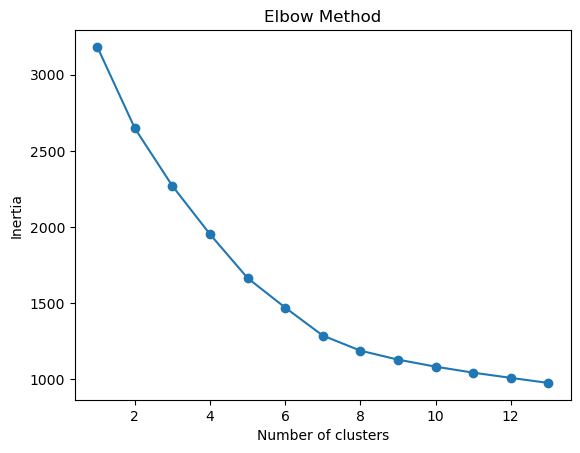

In [62]:
from sklearn.cluster import KMeans

inertias = []
cluster_range = range(1, 14)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(topic_prob_array)
    inertias.append(kmeans.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The plot shows a smooth curve without clear optimal points. But we can try 8 as the number of clusters.

In [67]:
# Choose the number of clusters
k = 8

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the topic probabilities
kmeans.fit(topic_prob_array)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the movie dataframe
ada_mpst_df['cluster'] = labels

# Check the result
ada_mpst_df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,cluster
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...,619,"[0.0016248829197138548, -0.017225325107574463,...",...,0.061404,0.000121,0.000121,0.002949,0.064167,0.032577,0.439993,0.036828,0.000121,4
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...,189,"[-0.0006041820743121207, -0.005067169666290283...",...,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.212958,0.000398,0.569340,6
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...,335,"[-0.011530309915542603, -0.012038590386509895,...",...,0.093903,0.000218,0.000218,0.000218,0.094778,0.439901,0.000218,0.104864,0.000218,1
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...,1074,"[-0.010470161214470863, -0.0004987613065168262...",...,0.000068,0.000068,0.000068,0.000068,0.032357,0.628521,0.014196,0.093302,0.000068,1
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...,1366,"[-0.023119330406188965, -0.010412095114588737,...",...,0.482529,0.000053,0.008709,0.000053,0.000053,0.112024,0.026707,0.096632,0.000053,5


Once we compare the 5 movies shown in our dataframe, the second clustering looks better.

In [68]:
# Count the number of movies per cluster
cluster_counts = ada_mpst_df['cluster'].value_counts()

# Print the number of movies for each cluster (excluding noise)
print("Number of movies per cluster:")
print(cluster_counts[cluster_counts.index != -1])

Number of movies per cluster:
1    2680
5    2353
0    2338
4    1740
3    1659
2    1530
6     976
7     889
Name: cluster, dtype: int64


The clustering algorithm was able to group a majority of the movies together in the first three clusters and the remaining clusters have significantly fewer movies.

In [69]:
from sklearn.cluster import KMeans

# Convert the embeddings column into a numpy array
embeddings_array = np.array(ada_mpst_df['ada_embeddings'].tolist())

# Initialize the KMeans model with desired number of clusters
kmeans_model = KMeans(n_clusters=8, random_state=42)

# Fit the model on the embeddings array
kmeans_model.fit(embeddings_array)

# Predict the clusters for each embedding
cluster_labels = kmeans_model.predict(embeddings_array)

# Add the cluster labels to the dataframe
ada_mpst_df['cluster_label'] = cluster_labels

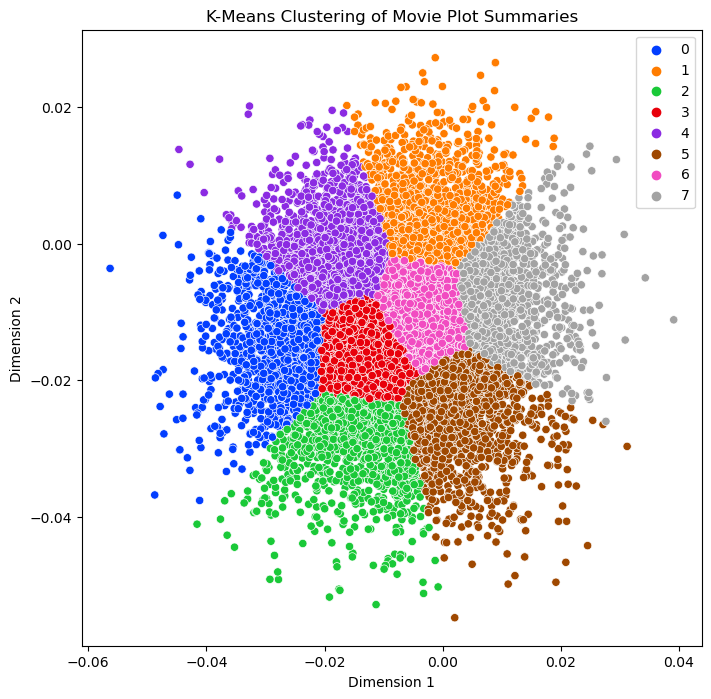

In [70]:
import seaborn as sns

# Extract the first two dimensions of the document embeddings
X = ada_mpst_df['ada_embeddings'].to_list()
X = [x[:2] for x in X]

# Fit the k-means clustering model
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Plot the data points colored by their cluster labels
plt.figure(figsize=(8, 8))
sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=labels, palette=sns.color_palette('bright', n_colors=8))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('K-Means Clustering of Movie Plot Summaries')
plt.show()


Although there appear to be 8 clusters, it is difficult to determine if they are properly clustered. In fact, it seems as though a large cluster has been divided into 8 sections rather than there being distinct, well-formed clusters.

Clustering based on movie synopses alone has limitations and may not always result in well-formed clusters. The main challenge is that movie synopses can be short and lack important contextual information, leading to a loss of meaning in the text. Additionally, some movies may belong to multiple genres, making it difficult to assign them to a single cluster. To complement the synopsis data, it would be useful to include other features such as cast and crew information, release date, and user ratings. These additional features could help to identify commonalities between movies beyond just their plots. Despite these challenges and limitations, our clustering analysis did provide us with a better understanding of the underlying themes and patterns in our dataset. By identifying these themes, we can make more accurate and personalized movie recommendations to users, ultimately improving their overall user experience.

## Summary

In conclusion, our analysis demonstrated the iterative and exploratory nature of unsupervised machine learning techniques applied to movie data. Although the clustering results were not as clearly separated as we initially hoped, we experimented with various approaches, such as `LDA` for topic modeling and `k-means` clustering. 

Throughout this process, we identified the limitations of clustering based solely on genres and latent topics.

Despite these challenges, we gained valuable insights into the dataset's structure and recognized the importance of incorporating additional features or dimensions to better capture the relationships between movies. This experience highlights the importance of trial and error and continuous improvement in data-driven analyses, ultimately enriching our understanding of complex data structures and fostering a positive approach to problem-solving in machine learning.

Now let's move onto our [**final supplementary notebook!**](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Supplementary/Supplementary_Part_4_Model_Selection.ipynb)

### Acknowledgement

- ["Generating WordClouds in Python Tutorial"](https://www.datacamp.com/tutorial/wordcloud-python) by Duong Vu was helpful in creating wordclouds.
- Some online articles were helpful in conductin LDA analysis, including ["Visualizing Unsupervised Text Classification Output with pyLDAvis"](https://medium.com/@nqabell89/visualizing-unsupervised-text-classification-output-with-pyldavis-370c1784ed58) by Nicholas Abell and ["Topic Modeling with Latent Dirichlet Allocations (LDA)"](https://medium.com/broadhorizon-cmotions/topic-modeling-with-latent-dirichlet-allocations-lda-ab7ed0eb6eac) by Konstantina Andronikou.